# Обучение обобщающего NN-классификатора новообразований молочной железы

- [train/val/test разбивка](#train/val/test-разбивка)
- [Конвертация из DataFrame в Dataset](#Конвертация-из-DataFrame-в-Dataset)
- [Модель](#Модель)

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf

import definitions as defs

### train/val/test разбивка

In [2]:
df = pd.read_excel(defs.PREPARED_DATA_PATH)


def train_val_test_split(dataframe, test_frac=.1, val_frac=.1):
    # рандом генератор
    rng = np.random.default_rng()
    # перетасованные индексы
    perm = rng.permutation(len(dataframe.index))
    
    size = len(perm) 
    test_end = int(test_frac * size)
    val_end = int(val_frac * size) + test_end
    
    test_part = dataframe.iloc[perm[:test_end]]
    val_part = dataframe.iloc[perm[test_end:val_end]]
    train_part = dataframe.iloc[perm[val_end:]]
    # небольшая справка о количестве точек данных в каждой из частей
    print('Train part:      {}'.format(len(train_part)))
    print('Validation part: {}'.format(len(val_part)))
    print('Test part:       {}'.format(len(test_part)))
    
    return train_part, val_part, test_part


train_df, val_df, test_df = train_val_test_split(df)

Train part:      468
Validation part: 58
Test part:       58


### Конвертация из DataFrame в Dataset

In [3]:
tf.config.experimental.set_visible_devices([], 'GPU')  # отключаю GPU, так как оно у меня слабое

In [4]:
def dataframe_to_dataset(dataframe, tmp_file_name):
    path_to_tmp_csv = os.path.join(os.getcwd(), 'data', tmp_file_name)
    # сохраняем DataFrame во временный CSV файл
    dataframe.to_csv(
        path_or_buf=path_to_tmp_csv,
        header=False,
        index=False,
    )
    # создаём Dataset, читая CSV файл
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=path_to_tmp_csv,
        batch_size=1,
        column_names=defs.INPUT_NAMES.keys(),
        label_name='label',
        header=False,
        num_epochs=1
    )
    # one-hot-encoding метки
    dataset = dataset.map(lambda p, l: (p, tf.one_hot(l, depth=3)))
    dataset.batch(1)
    # удалим временный CSV файл
    # os.remove(path_to_tmp_csv)
    
    return dataset


entire_ds = dataframe_to_dataset(df, 'tmp entire.csv')
train_ds = dataframe_to_dataset(train_df, 'tmp train.csv')
val_ds = dataframe_to_dataset(val_df, 'tmp val.csv')
test_ds = dataframe_to_dataset(test_df, 'tmp test.csv')

## Модель

In [5]:
defs.INPUT_NAMES.pop('label')

In [6]:
def create_inputs():
    """ Создаёт список из входов """
    inputs = [
        tf.keras.Input(shape=(1,), name=input_name, dtype='float64')
        if defs.INPUT_NAMES[input_name] == 'numerical'
        else tf.keras.Input(shape=(1,), name=input_name, dtype='int64')
        for input_name in defs.INPUT_NAMES
    ]
    
    return inputs


def encode_inputs(inputs):
    def encode_numerical_input(inpt, dataset=entire_ds):
        # Создание слоя нормализации для признака
        normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
        # Подгатавливаем Dataset, который содержит только необходимый признак
        feature_ds = dataset.map(lambda x, y: x[inpt.name])
        feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
        # Изучается статистика данных
        normalizer.adapt(feature_ds)
        # Нормализация входного признака
        encoded_feature = normalizer(inpt)

        return encoded_feature
    
    
    def encode_categorical_input(inpt, dataset=entire_ds):
        lookup = tf.keras.layers.experimental.preprocessing.IntegerLookup(
            output_mode='binary',
            num_oov_indices=0,
            mask_token=-1
        )
        # Подгатавливаем Dataset, который содержит только необходимый признак
        feature_ds = dataset.map(lambda x, y: x[inpt.name])
        feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
        # Изучаем набор возможных строковых значений и присваиваем им фиксированный целочисленный индекс
        lookup.adapt(feature_ds)
        # Превращаем строковый вход в целочисленные индексы
        encoded_feature = lookup(inpt)

        return encoded_feature

    
    encoded_features = [
        encode_numerical_input(inpt)
        if defs.INPUT_NAMES[inpt.name] == 'numerical'
        else encode_categorical_input(inpt)
        for inpt in inputs
    ]
    
    return encoded_features

In [7]:
def create_model():
    inputs = create_inputs()
    encoded_inputs = encode_inputs(inputs)
    x = tf.keras.layers.concatenate(encoded_inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs, output)
    
    return model


model = create_model()

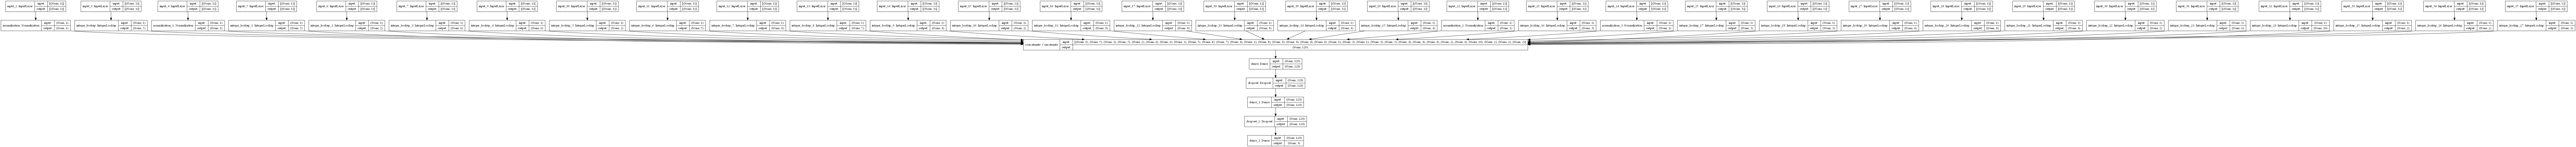

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TB', dpi=100)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
NUM_EPOCHS = 100


checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=defs.GENERALIZING_MODEL,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
callbacks_list = [checkpoint]

history = model.fit(train_ds, epochs=NUM_EPOCHS, verbose=0, callbacks=callbacks_list, validation_data=val_ds)

INFO:tensorflow:Assets written to: C:\Users\Mikhail\Desktop\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: C:\Users\Mikhail\Desktop\Breast-Cancer\models\generalizing model\assets


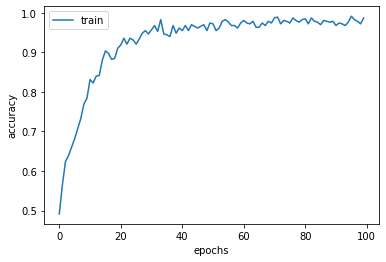

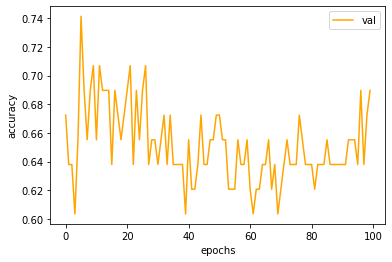

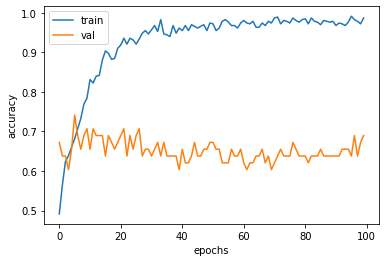

In [11]:
def plot_history(history, mode):
    ax1 = plt.subplot()
    ax1.plot(history.history['%s' % mode])
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('%s' % mode)
    ax1.legend(['train'])
    plt.show()
    
    ax2 = plt.subplot()
    ax2.plot(history.history['val_%s' % mode], color='orange')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('%s' % mode)
    ax2.legend(['val'])
    plt.show()
    
    ax3 = plt.subplot()
    ax3.plot(history.history['%s' % mode])
    ax3.plot(history.history['val_%s' % mode])
    ax3.set_xlabel('epochs')
    ax3.set_ylabel('%s' % mode)
    ax3.legend(['train', 'val'])
    plt.show()


plot_history(history, 'accuracy')

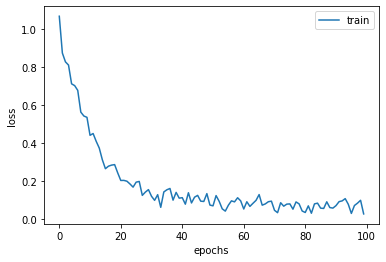

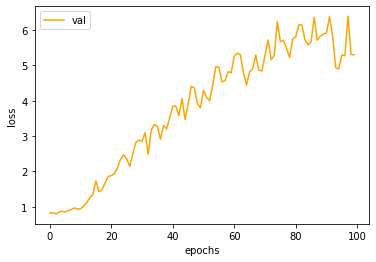

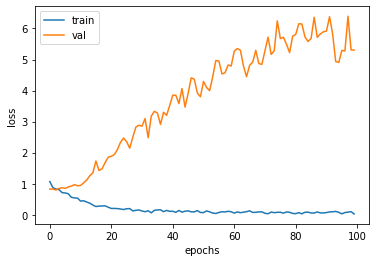

In [12]:
plot_history(history, 'loss')